# Imports

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import pad_sequences


import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

We will use quijote.txt from the previous exercise

In [2]:
df = pd.read_csv('../ejercicio3/quijote.txt', sep='/n', header=None, engine='python')

df.head(30)

,0
0,TASA
1,"Yo, Juan Gallo de Andrada, escribano de Cámara..."
2,Juan Gallo de Andrada.
3,TESTIMONIO DE LAS ERRATAS
4,Este libro no tiene cosa digna que no correspo...
5,El licenciado Francisco Murcia de la Llana.
6,EL REY
7,"Por cuanto por parte de vos, Miguel de Cervant..."
8,"YO, EL REY."
9,Por mandado del Rey nuestro señor:


In [3]:
print("Total sentences:", df.shape[0])

Total sentences: 6239


# Pre-processing

In [4]:
from keras.preprocessing.text import text_to_word_sequence
import unicodedata
import re

pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]'

sentence_tokens = []
for _, row in df[:None].iterrows():
    ttw = text_to_word_sequence(row[0])
    ttw_processed = []
    for word in ttw:
        word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        word = re.sub(pattern, '', word)
        ttw_processed.append(word)
    sentence_tokens.append(ttw_processed)

In [5]:
sentence_tokens[1]

['yo',
 'juan',
 'gallo',
 'de',
 'andrada',
 'escribano',
 'de',
 'camara',
 'del',
 'rey',
 'nuestro',
 'senor',
 'de',
 'los',
 'que',
 'residen',
 'en',
 'su',
 'consejo',
 'certifico',
 'y',
 'doy',
 'fe',
 'que',
 'habiendo',
 'visto',
 'por',
 'los',
 'senores',
 'del',
 'un',
 'libro',
 'intitulado',
 'el',
 'ingenioso',
 'hidalgo',
 'de',
 'la',
 'mancha',
 'compuesto',
 'por',
 'miguel',
 'de',
 'cervantes',
 'saavedra',
 'tasaron',
 'cada',
 'pliego',
 'del',
 'dicho',
 'libro',
 'a',
 'tres',
 'maravedis',
 'y',
 'medio',
 'el',
 'cual',
 'tiene',
 'ochenta',
 'y',
 'tres',
 'pliegos',
 'que',
 'al',
 'dicho',
 'precio',
 'monta',
 'el',
 'dicho',
 'libro',
 'docientos',
 'y',
 'noventa',
 'maravedis',
 'y',
 'medio',
 'en',
 'que',
 'se',
 'ha',
 'de',
 'vender',
 'en',
 'papel',
 'y',
 'dieron',
 'licencia',
 'para',
 'que',
 'a',
 'este',
 'precio',
 'se',
 'pueda',
 'vender',
 'y',
 'mandaron',
 'que',
 'esta',
 'tasa',
 'se',
 'ponga',
 'al',
 'principio',
 'del',
 'di

In [6]:
TRAIN_LEN = 4

In [7]:
text_sequences = []

for tokens in sentence_tokens:
    for i in range(TRAIN_LEN, len(tokens)):
      seq = tokens[i-TRAIN_LEN:i]
      text_sequences.append(seq)

In [8]:
text_sequences[:30]

[['yo', 'juan', 'gallo', 'de'],
 ['juan', 'gallo', 'de', 'andrada'],
 ['gallo', 'de', 'andrada', 'escribano'],
 ['de', 'andrada', 'escribano', 'de'],
 ['andrada', 'escribano', 'de', 'camara'],
 ['escribano', 'de', 'camara', 'del'],
 ['de', 'camara', 'del', 'rey'],
 ['camara', 'del', 'rey', 'nuestro'],
 ['del', 'rey', 'nuestro', 'senor'],
 ['rey', 'nuestro', 'senor', 'de'],
 ['nuestro', 'senor', 'de', 'los'],
 ['senor', 'de', 'los', 'que'],
 ['de', 'los', 'que', 'residen'],
 ['los', 'que', 'residen', 'en'],
 ['que', 'residen', 'en', 'su'],
 ['residen', 'en', 'su', 'consejo'],
 ['en', 'su', 'consejo', 'certifico'],
 ['su', 'consejo', 'certifico', 'y'],
 ['consejo', 'certifico', 'y', 'doy'],
 ['certifico', 'y', 'doy', 'fe'],
 ['y', 'doy', 'fe', 'que'],
 ['doy', 'fe', 'que', 'habiendo'],
 ['fe', 'que', 'habiendo', 'visto'],
 ['que', 'habiendo', 'visto', 'por'],
 ['habiendo', 'visto', 'por', 'los'],
 ['visto', 'por', 'los', 'senores'],
 ['por', 'los', 'senores', 'del'],
 ['los', 'senores', 

In [9]:
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

In [10]:
sequences = tok.texts_to_sequences(text_sequences)

In [11]:
sequences[:30]

[[25, 946, 3340, 2],
 [946, 3340, 2, 7884],
 [3340, 2, 7884, 1883],
 [2, 7884, 1883, 2],
 [7884, 1883, 2, 3419],
 [1883, 2, 3419, 17],
 [2, 3419, 17, 291],
 [3419, 17, 291, 187],
 [17, 291, 187, 47],
 [291, 187, 47, 2],
 [187, 47, 2, 10],
 [47, 2, 10, 1],
 [2, 10, 1, 5083],
 [10, 1, 5083, 7],
 [1, 5083, 7, 15],
 [5083, 7, 15, 592],
 [7, 15, 592, 7885],
 [15, 592, 7885, 3],
 [592, 7885, 3, 651],
 [7885, 3, 651, 413],
 [3, 651, 413, 1],
 [651, 413, 1, 430],
 [413, 1, 430, 137],
 [1, 430, 137, 12],
 [430, 137, 12, 10],
 [137, 12, 10, 264],
 [12, 10, 264, 17],
 [10, 264, 17, 28],
 [264, 17, 28, 322],
 [17, 28, 322, 4358]]

In [12]:
print(tok.word_index)

{'que': 1, 'de': 2, 'y': 3, 'la': 4, 'a': 5, 'el': 6, 'en': 7, 'no': 8, 'se': 9, 'los': 10, 'con': 11, 'por': 12, 'las': 13, 'lo': 14, 'su': 15, 'le': 16, 'del': 17, 'como': 18, 'don': 19, 'me': 20, 'si': 21, 'mas': 22, 'mi': 23, 'es': 24, 'yo': 25, 'quijote': 26, 'sancho': 27, 'un': 28, 'al': 29, 'para': 30, 'porque': 31, 'ni': 32, 'una': 33, 'dijo': 34, 'tan': 35, 'o': 36, 'sin': 37, 'todo': 38, 'esta': 39, 'ha': 40, 'ser': 41, 'habia': 42, 'sus': 43, 'pero': 44, 'bien': 45, 'asi': 46, 'senor': 47, 'respondio': 48, 'merced': 49, '': 50, 'quien': 51, 'vuestra': 52, 'esto': 53, 'todos': 54, 'este': 55, 'era': 56, 'pues': 57, 'cuando': 58, 'ya': 59, 'cual': 60, 'donde': 61, 'sino': 62, 'te': 63, 'dos': 64, 'caballero': 65, 'fue': 66, 'ella': 67, 'decir': 68, 'tu': 69, 'hacer': 70, 'aunque': 71, 'aquel': 72, 'he': 73, 'muy': 74, 'otra': 75, 'dios': 76, 'otro': 77, 'senora': 78, 'aqui': 79, 'son': 80, 'estaba': 81, 'hay': 82, 'sobre': 83, 'os': 84, 'nos': 85, 'mal': 86, 'cosa': 87, 'buen'

In [13]:
print(tok.word_docs)

defaultdict(<class 'int'>, {'yo': 7809, 'juan': 139, 'gallo': 30, 'de': 68287, 'andrada': 8, 'escribano': 62, 'camara': 28, 'del': 9760, 'rey': 514, 'nuestro': 785, 'senor': 3822, 'los': 18021, 'que': 81100, 'residen': 16, 'en': 30897, 'su': 12589, 'consejo': 238, 'certifico': 8, 'y': 68121, 'doy': 213, 'fe': 361, 'habiendo': 339, 'visto': 1088, 'por': 14889, 'senores': 555, 'un': 7386, 'libro': 463, 'intitulado': 20, 'el': 35194, 'ingenioso': 83, 'hidalgo': 254, 'la': 38674, 'mancha': 562, 'compuesto': 60, 'miguel': 64, 'cervantes': 47, 'saavedra': 28, 'tasaron': 8, 'cada': 860, 'pliego': 52, 'dicho': 1406, 'a': 36578, 'tres': 881, 'maravedis': 64, 'medio': 374, 'cual': 2866, 'tiene': 1498, 'ochenta': 24, 'pliegos': 16, 'al': 6559, 'precio': 74, 'monta': 27, 'docientos': 76, 'noventa': 12, 'se': 19518, 'ha': 4059, 'vender': 56, 'papel': 156, 'dieron': 332, 'licencia': 288, 'para': 5633, 'este': 2995, 'pueda': 312, 'mandaron': 12, 'esta': 4235, 'tasa': 36, 'ponga': 120, 'principio': 24

# Preparing input

In [14]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1]

print(x_data.shape)
print(y_data_int.shape)

(359594, 3)
(359594,)


In [15]:
total_num_words = len(tok.word_counts)

In [16]:
y_data = to_categorical(y_data_int, num_classes=total_num_words)

In [17]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=total_num_words)
y_data.shape

(359594, 22102)

# Training

In [20]:
input_seq_len = x_data.shape[1]
output_size = total_num_words

In [21]:
model = Sequential()

model.add(Embedding(input_dim=output_size + 1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))

model.add(Dense(output_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              110515    
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 22102)             729366    
                                                                 
Total params: 892,905
Trainable params: 892,905
Non-trai

In [142]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
8990/8990 [==============================] - 141s 15ms/step - loss: 6.6286 - accuracy: 0.0605 - val_loss: 6.5633 - val_accuracy: 0.0706
Epoch 2/50
8990/8990 [==============================] - 152s 17ms/step - loss: 6.1968 - accuracy: 0.0900 - val_loss: 6.4120 - val_accuracy: 0.1013
Epoch 3/50
8990/8990 [==============================] - 139s 16ms/step - loss: 5.9195 - accuracy: 0.1075 - val_loss: 6.3391 - val_accuracy: 0.1110
Epoch 4/50
8990/8990 [==============================] - 141s 16ms/step - loss: 5.7301 - accuracy: 0.1169 - val_loss: 6.2938 - val_accuracy: 0.1146
Epoch 5/50
8990/8990 [==============================] - 143s 16ms/step - loss: 5.5986 - accuracy: 0.1245 - val_loss: 6.2859 - val_accuracy: 0.1157
Epoch 6/50
8990/8990 [==============================] - 143s 16ms/step - loss: 5.5047 - accuracy: 0.1295 - val_loss: 6.2992 - val_accuracy: 0.1170
Epoch 7/50
8990/8990 [==============================] - 138s 15ms/step - loss: 5.4320 - accuracy: 0.1336 - val_loss: 6

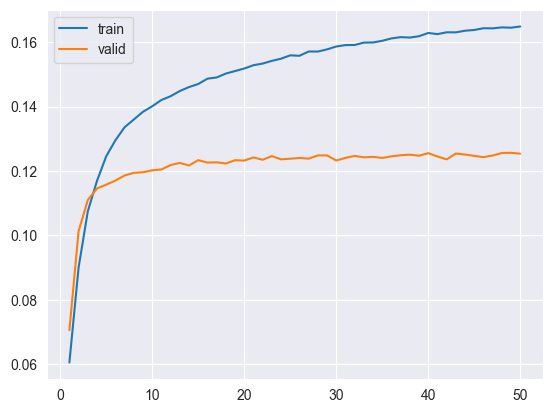

In [143]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

# Testing

In [22]:
import sys
!{sys.executable} -m pip install gradio==3.35.2 --quiet


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import gradio as gr

def model_response(human_text):

    encoded = tok.texts_to_sequences([human_text])[0]
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    y_hat = model.predict(encoded).argmax(axis=-1)

    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_6932\503840042.py:18: UserWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 18ms/step
Keyboard interruption in main thread... closing server.
